**Import all the needed dependencies**

In [15]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt

In [16]:
# Loading the datasets into a pandas dataframe
route_data = pd.read_csv("/content/bus_processed_output.csv")
weather_data = pd.read_csv("/content/chennai-monthly-rains.csv")

In [17]:
# Preprocessing the weather Data (2021 as example year)
weather_2021 = weather_data[weather_data["Year"] == 2021].iloc[0]
months = ["Jan", "Feb", "Mar", "April", "May", "June", "July", "Aug", "Sept", "Oct", "Nov", "Dec"]
days_in_month = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]  # Non-leap year
daily_rainfall = {month: weather_2021[month] / days for month, days in zip(months, days_in_month)}

In [18]:
# Assigning random month to each route
np.random.seed(42)
route_data["Month"] = np.random.choice(months, size=len(route_data))
route_data["Daily_Rainfall"] = route_data["Month"].map(daily_rainfall)

In [19]:
# Create synthetic Delay target (rainfall_index > 50 or Daily_Rainfall > 50 mm/day)
route_data["Delay"] = ((route_data["rainfall_index"] > 50) | (route_data["Daily_Rainfall"] > 50)).astype(int)

In [20]:
# Preprocessing Route Data
features = ["starting_point", "ending_point", "bus_count", "high_frequency_route",
            "night_service_route", "low_frequency_route", "rainfall_index", "Daily_Rainfall"]
X = route_data[features]
y = route_data["Delay"]

In [21]:
# One-hot encoding the categorical variables
X = pd.get_dummies(X, columns=["starting_point", "ending_point"], drop_first=True)

In [22]:
# Scaling the numerical features
scaler = StandardScaler()
num_cols = ["bus_count", "rainfall_index", "Daily_Rainfall"]
X[num_cols] = scaler.fit_transform(X[num_cols])

In [23]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [24]:
# Training the XGBoost model
model = XGBClassifier(n_estimators=100, max_depth=5, learning_rate=0.1, random_state=42,
                      eval_metric="logloss")
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [25]:
# Predictions
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

In [26]:
# Evaluation Metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

In [27]:
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print("\nConfusion Matrix:")
print(conf_matrix)

Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1-Score: 1.0000

Confusion Matrix:
[[73  0]
 [ 0 73]]


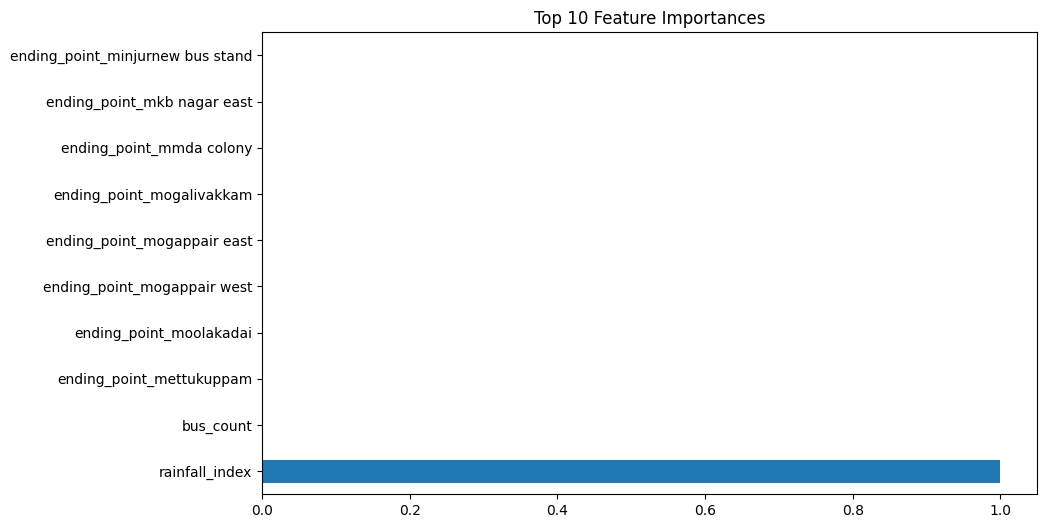

In [28]:
# Feature Importance
feat_importance = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)[:10]
plt.figure(figsize=(10, 6))
feat_importance.plot(kind="barh")
plt.title("Top 10 Feature Importances")
plt.show()


Predictions on Simulated Unseen Data:
[1 0 0 0 0 0 1 0 0 0]
